In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_california_housing

Load bostod housing dataset

In [2]:
from sklearn.datasets import load_boston
print(load_boston()['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [3]:
dataset = pd.DataFrame(data=load_boston()['data'], columns=load_boston()['feature_names'])
X = dataset.values
y = load_boston()['target']

In [4]:
dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [5]:
feature_type_mapping = {
    'CRIM': 'continuous',
    'ZN': 'continuous',
    'INDUS': 'continuous',
    'CHAS': 'discrete',
    'NOX': 'continuous',
    'RM': 'continuous',
    'AGE': 'continuous',
    'DIS': 'continuous',
    'RAD': 'discrete',
    'TAX': 'continuous',
    'PTRATIO': 'continuous',
    'B': 'continuous',
    'LSTAT': 'continuous'
}

Create regression model

In [6]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_leaf=10)
model.fit(X, y)

/home/waldemar/.virtualenvs/besmart_1.0/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

# PDP plots

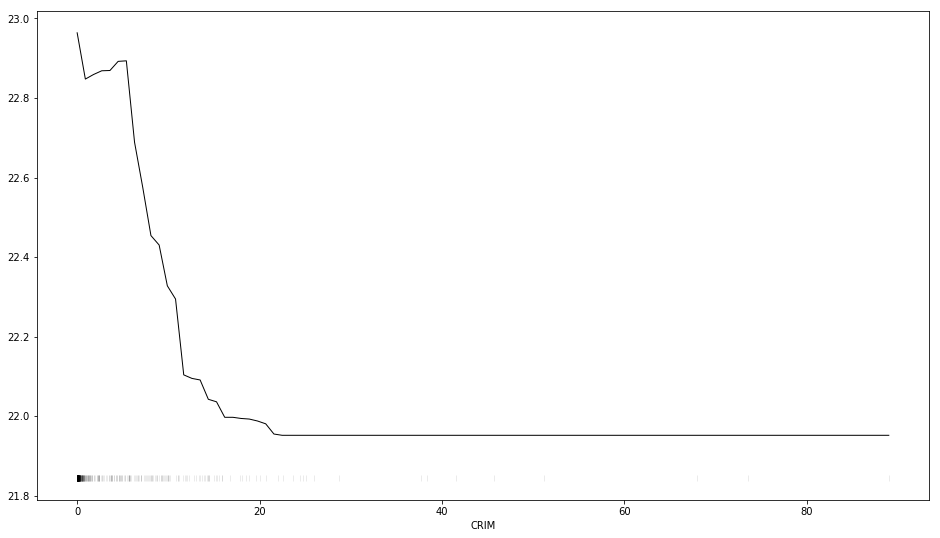

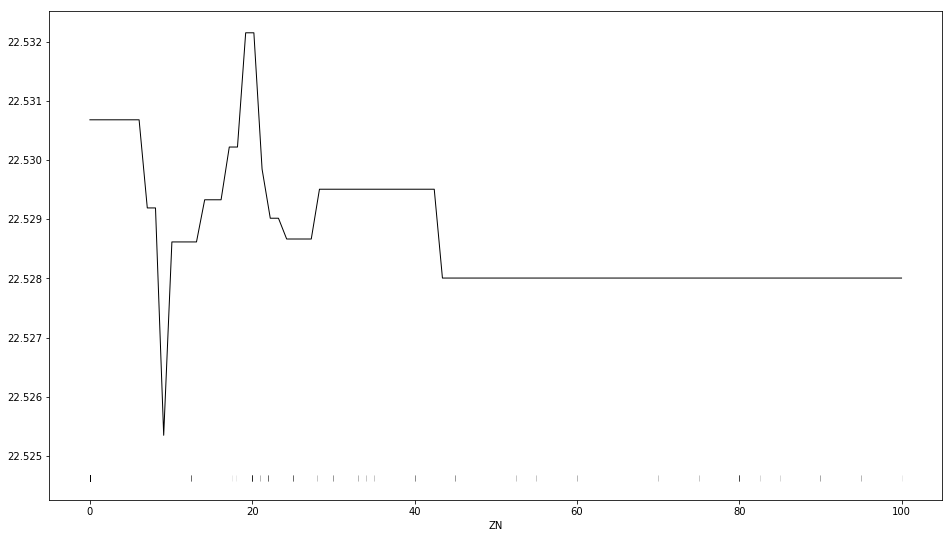

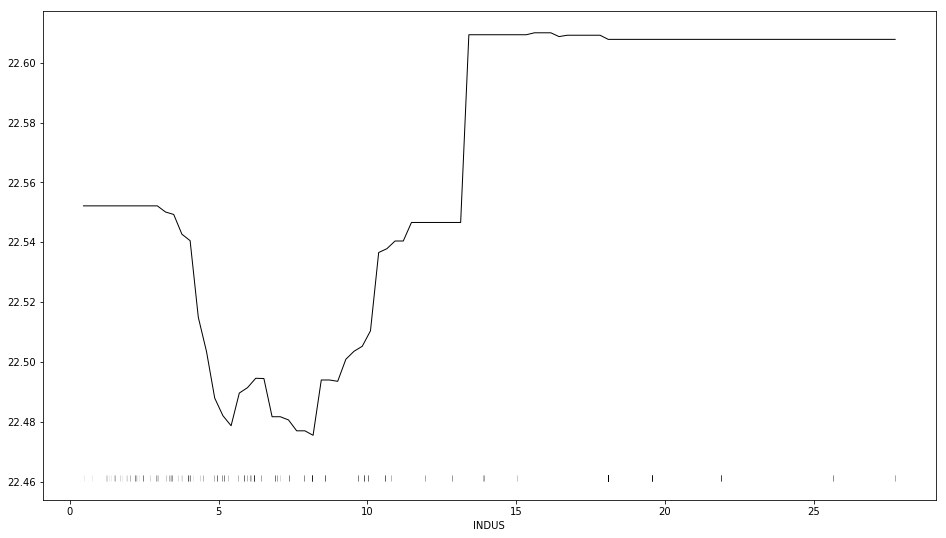

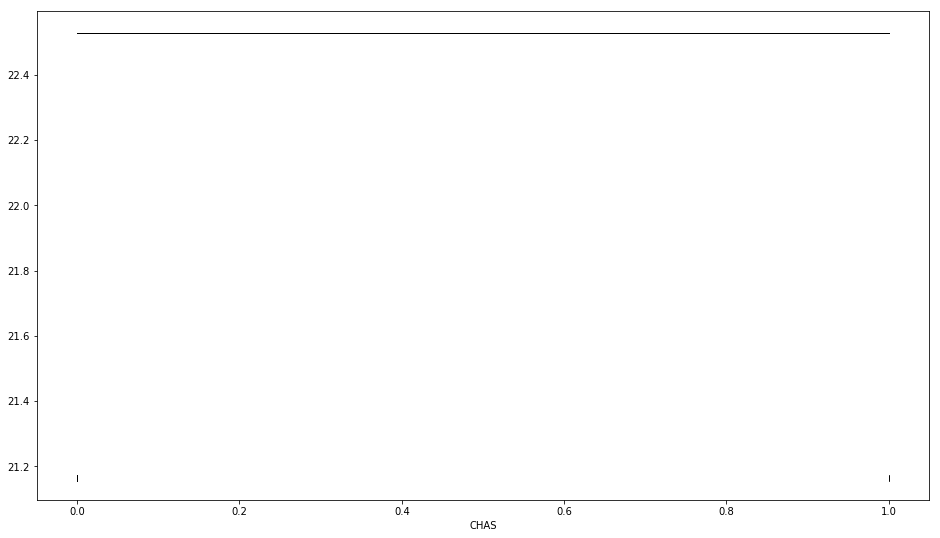

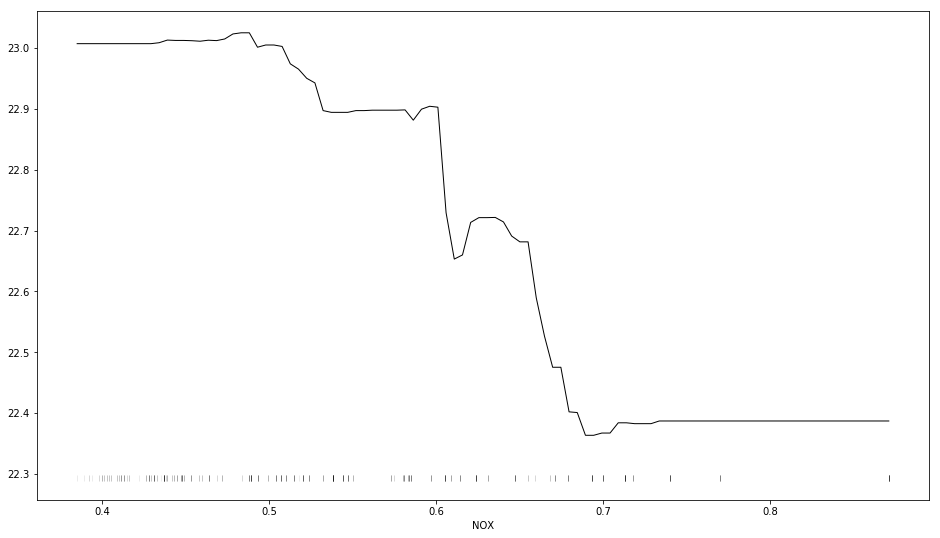

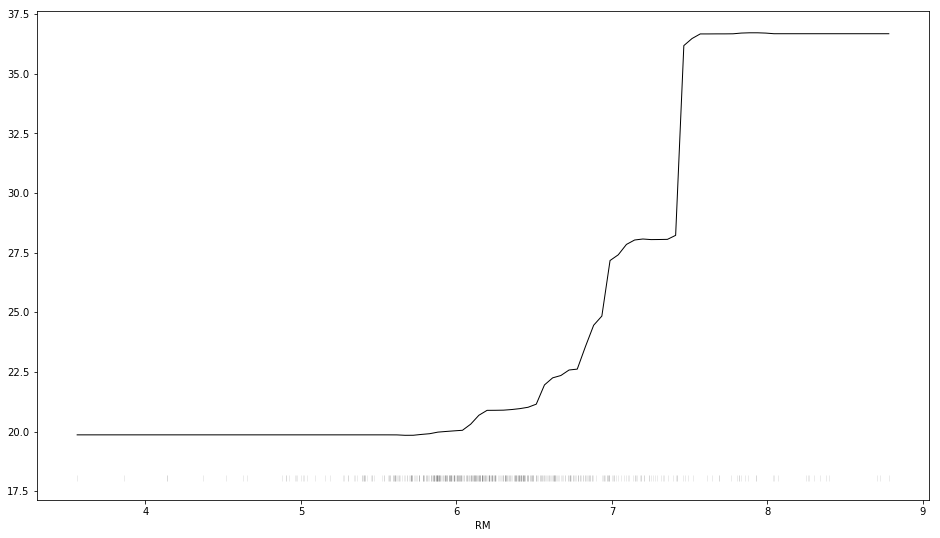

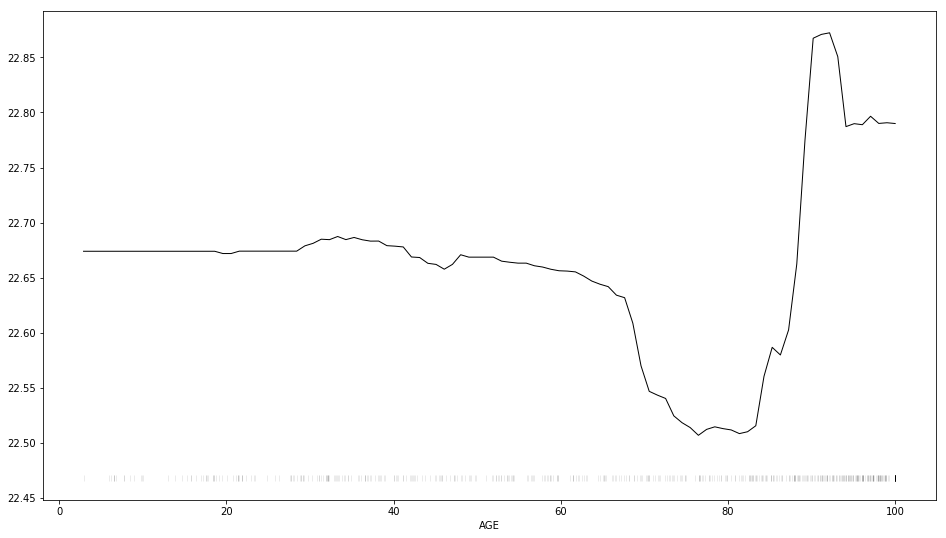

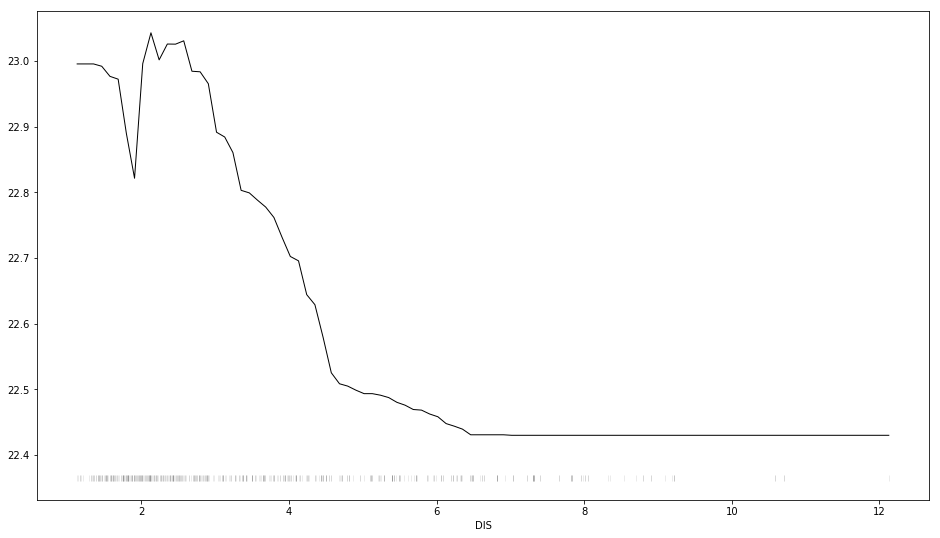

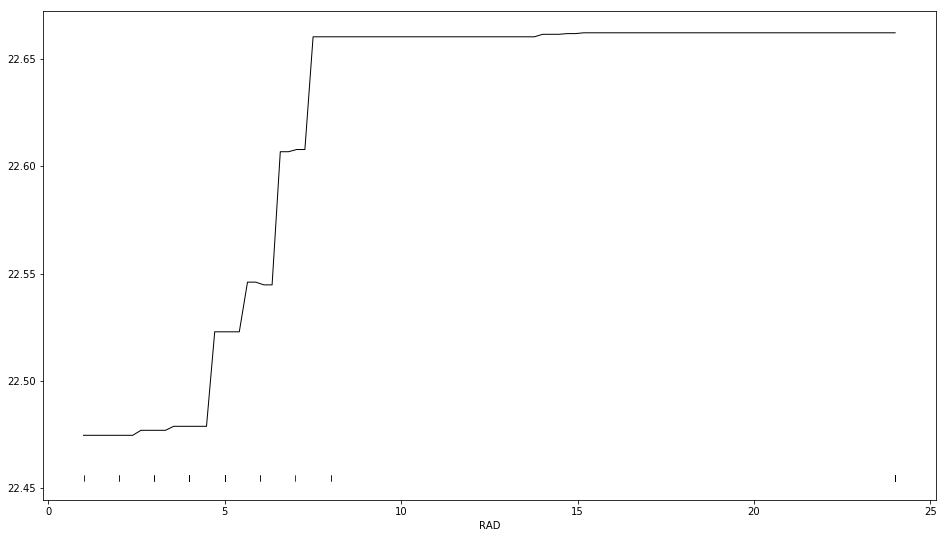

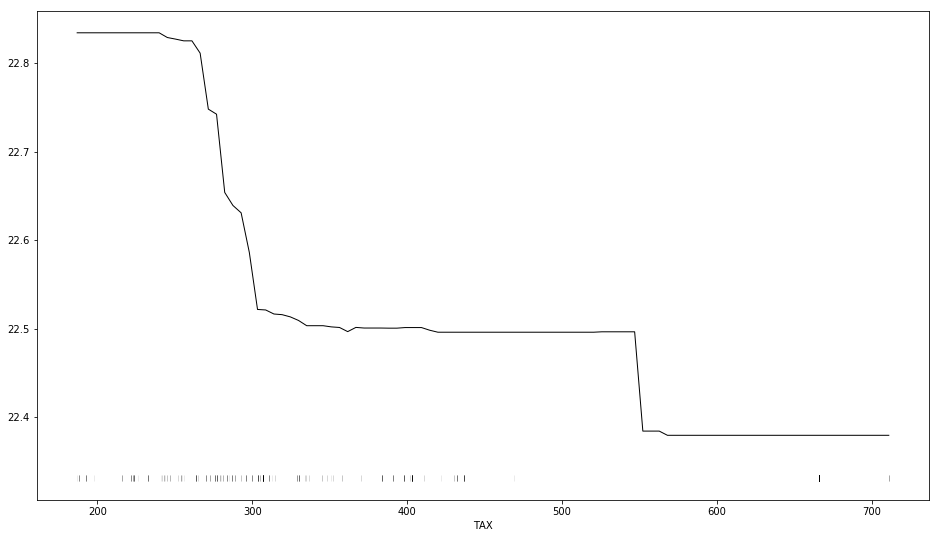

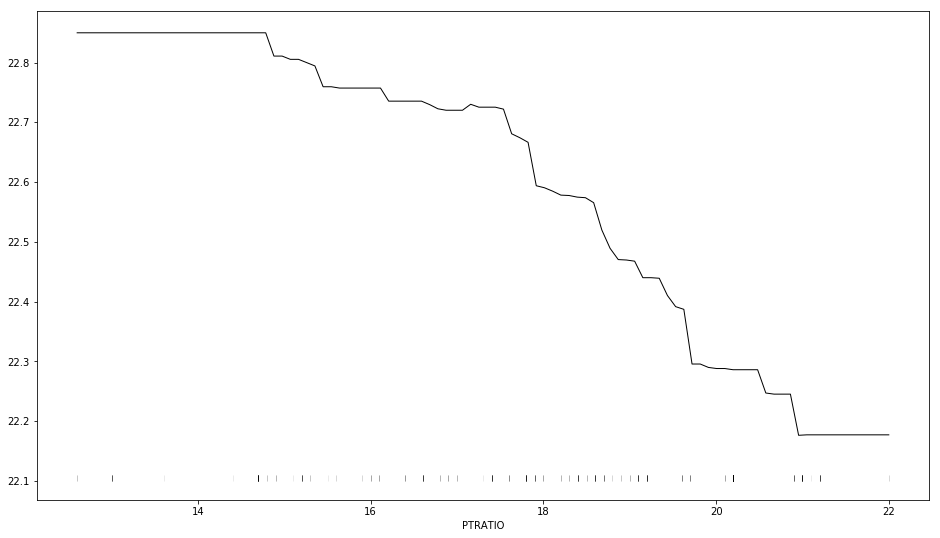

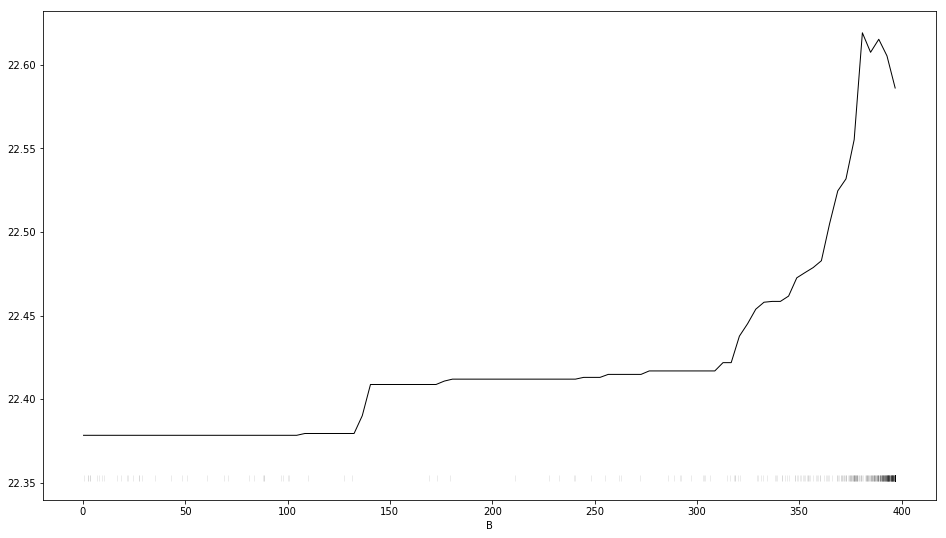

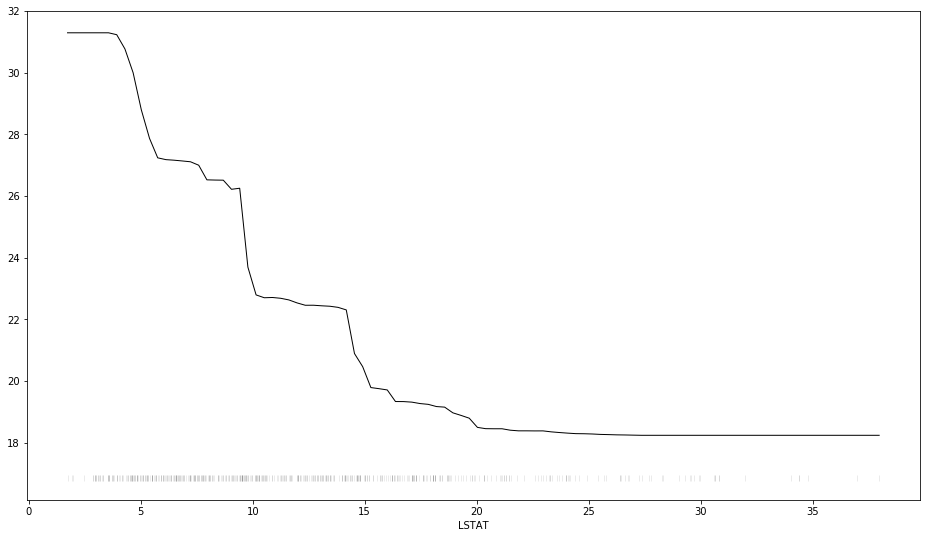

In [7]:
from partial_dependence_plot import plot_pdp

for f, feature_name in enumerate(dataset.columns):
    
    feature_type = 'continuous'
#     feature_type = feature_type_mapping[feature_name]
    pdp_df = plot_pdp(model=model,
                      features=X, 
                      feature_number=f, 
                      feature_name=feature_name, 
                      feature_type=feature_type)

    if feature_type == 'discrete':
        pdp_df.plot(figsize=(16, 9), 
                    legend=False, 
                    marker='o', 
                    linewidth=0.2, 
                    markersize=3, 
                    color='black')
        
    elif feature_type == 'continuous':
        pdp_df.plot(figsize=(16, 9), 
                    legend=False, 
                    linewidth=1, 
                    color='black')
        ax = plt.gca()
        bottom, top = ax.get_ylim()
        indicator_height = 0.05 * (top - bottom)
        ax.plot(dataset[feature_name].values, 
                [bottom - indicator_height]*dataset.shape[0], 
                '|', 
                color='k', 
                alpha=0.08)

# ICE plots

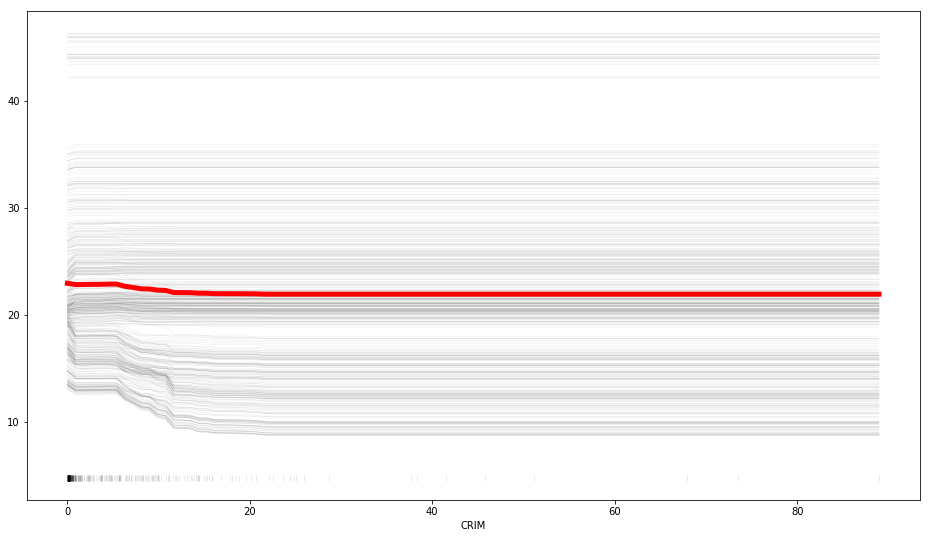

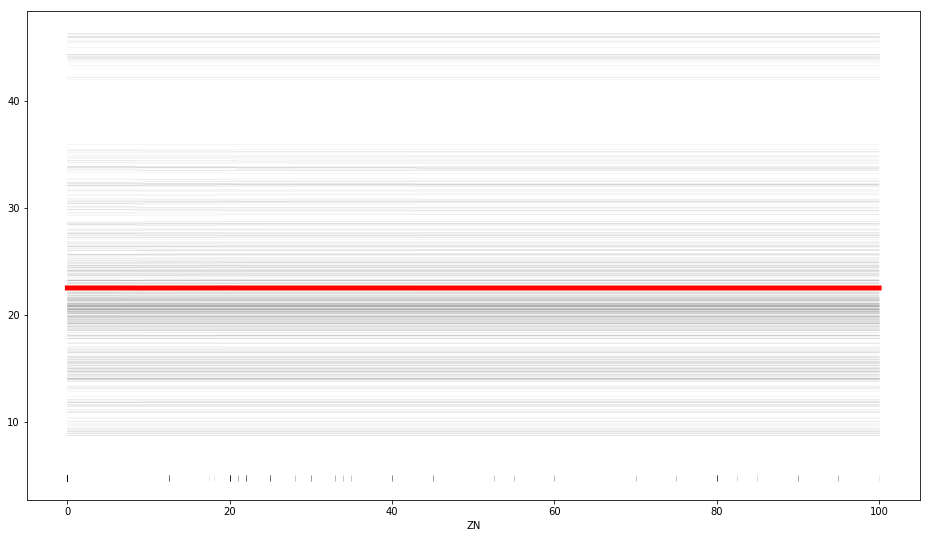

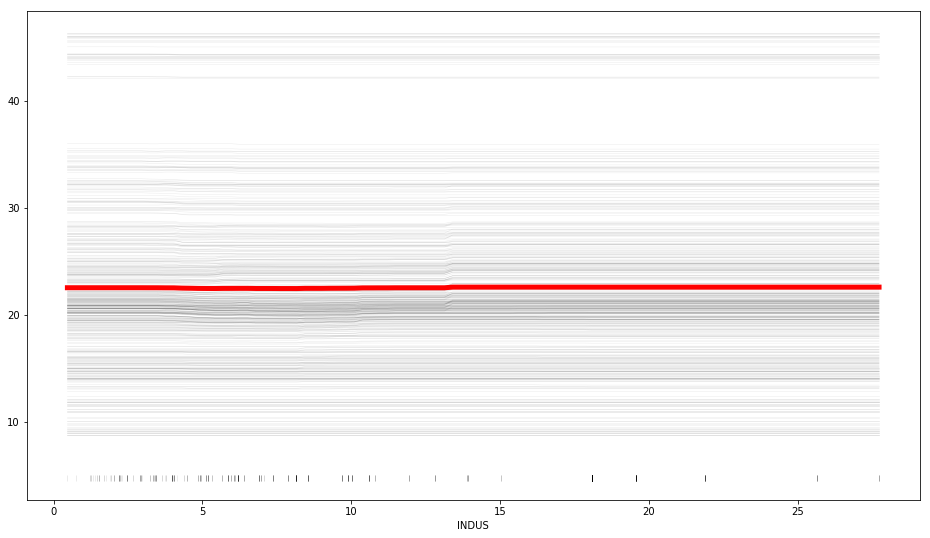

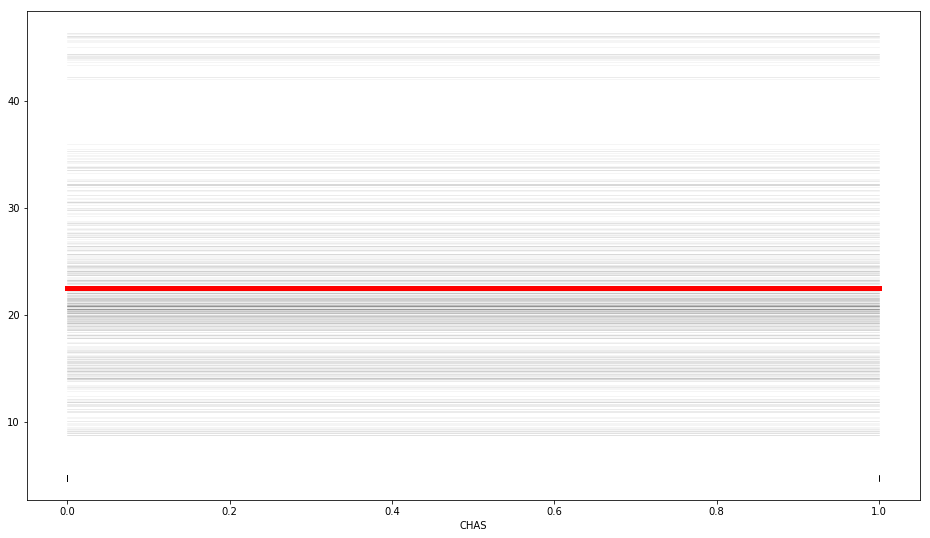

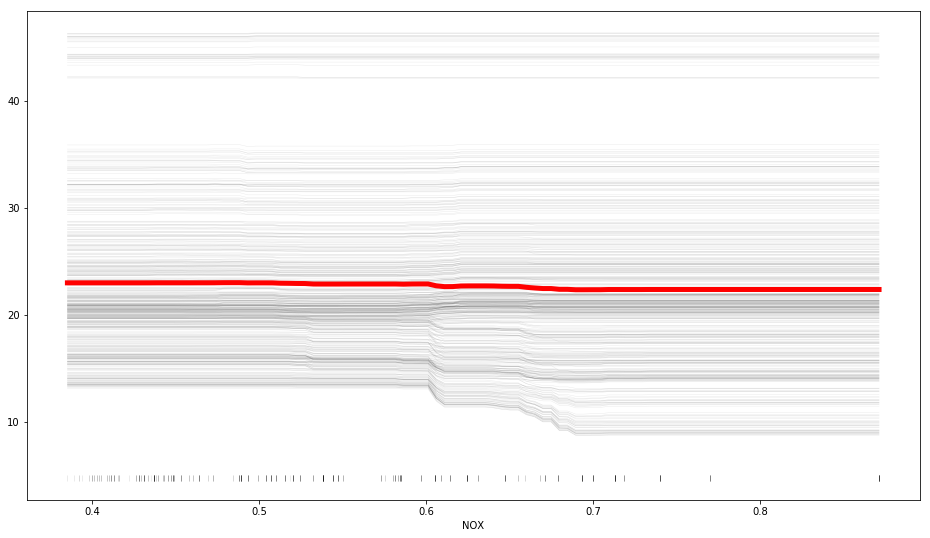

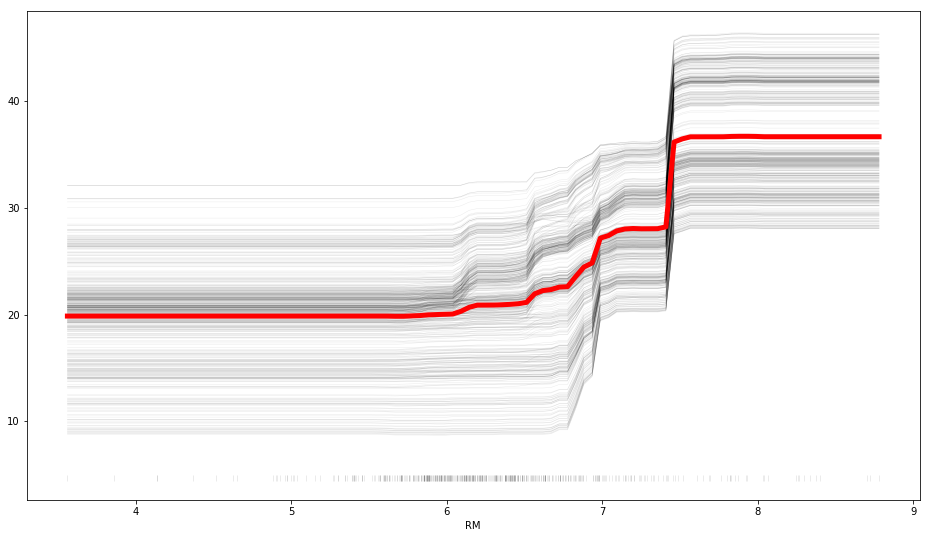

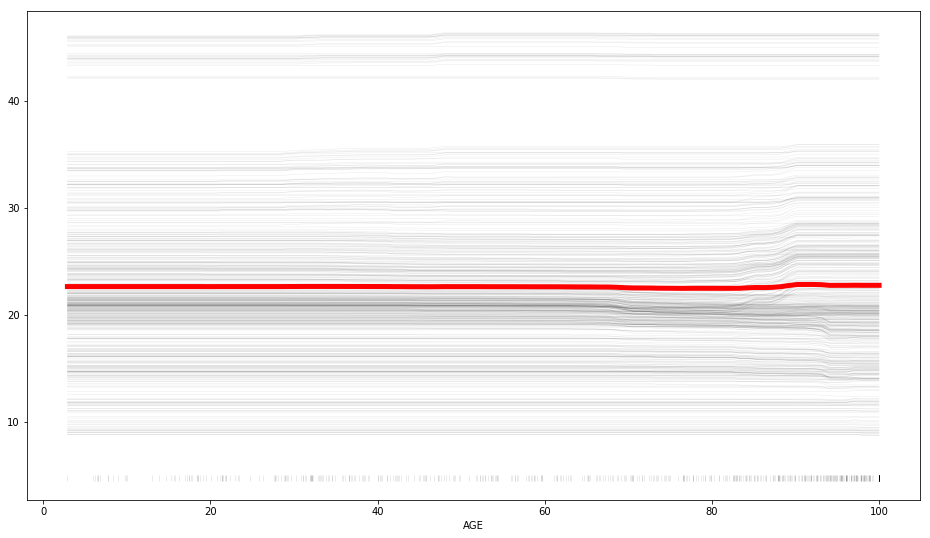

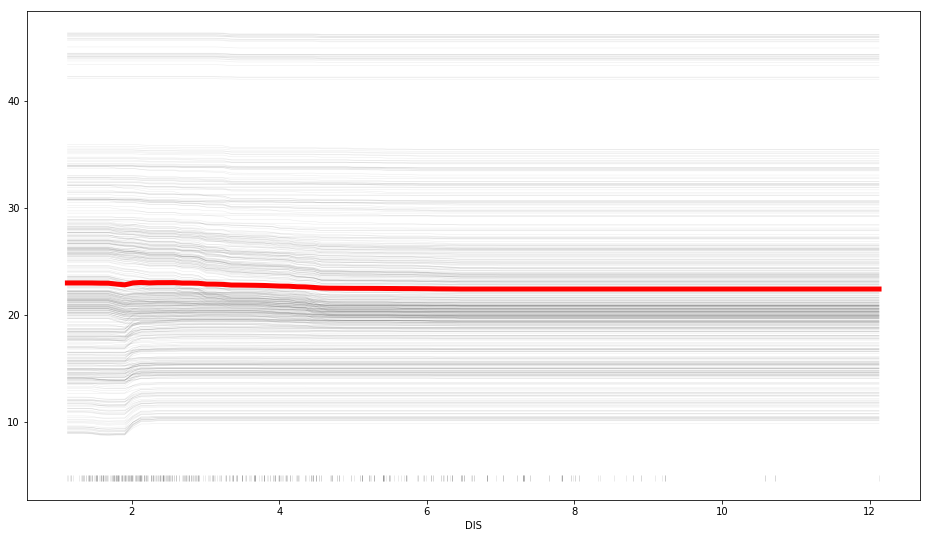

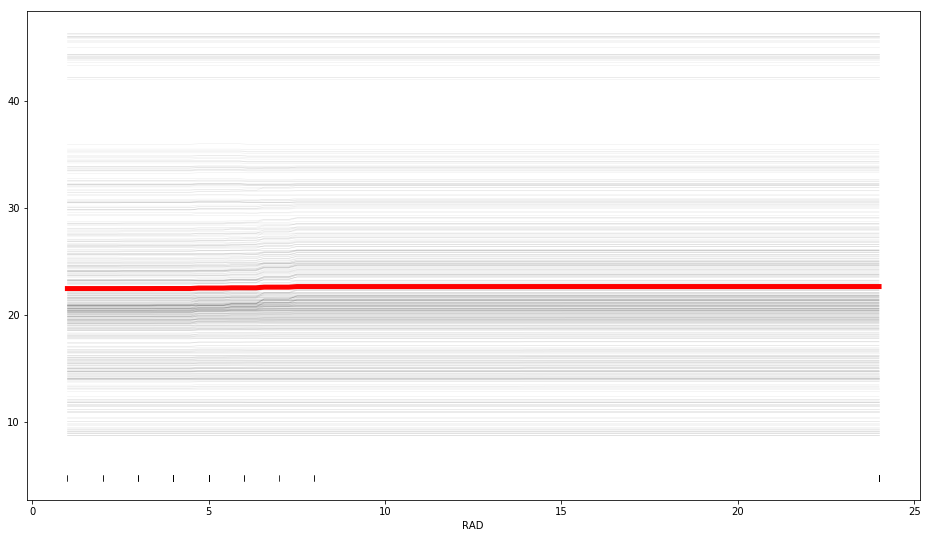

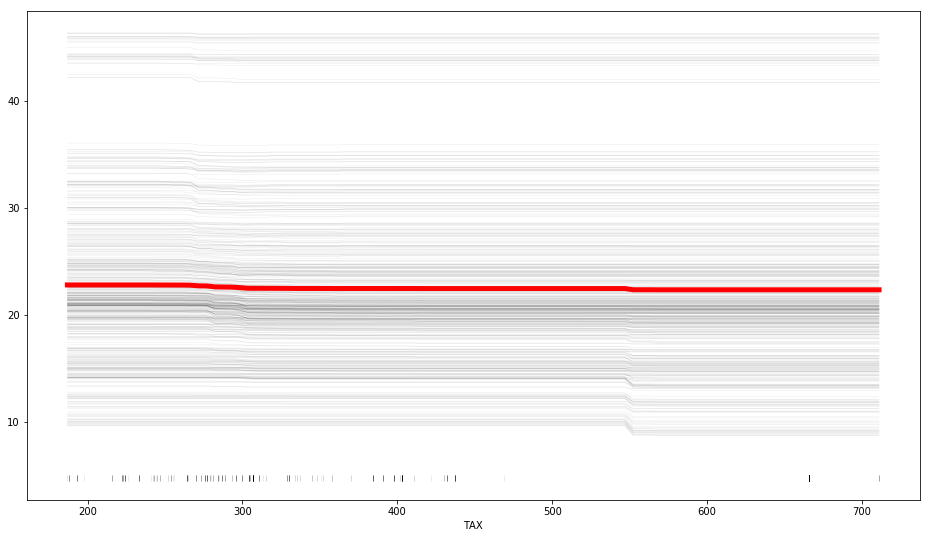

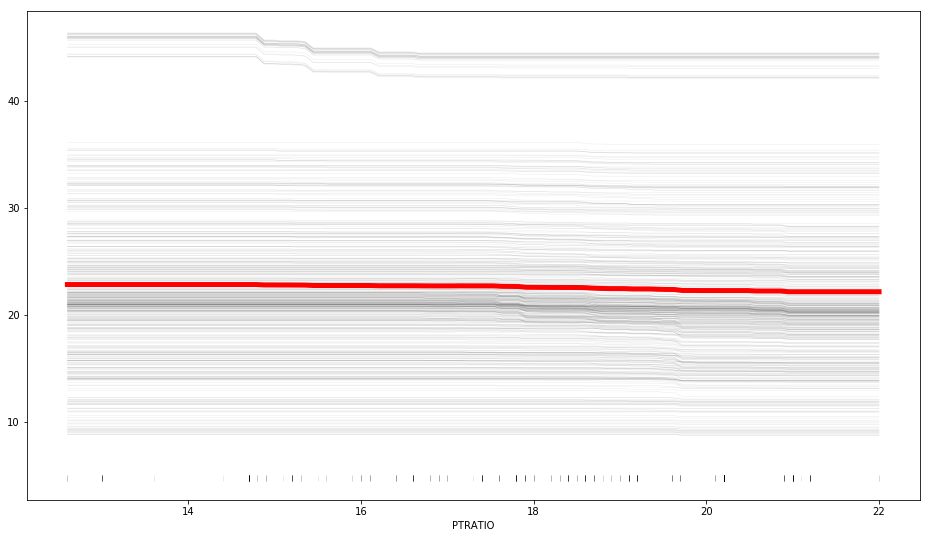

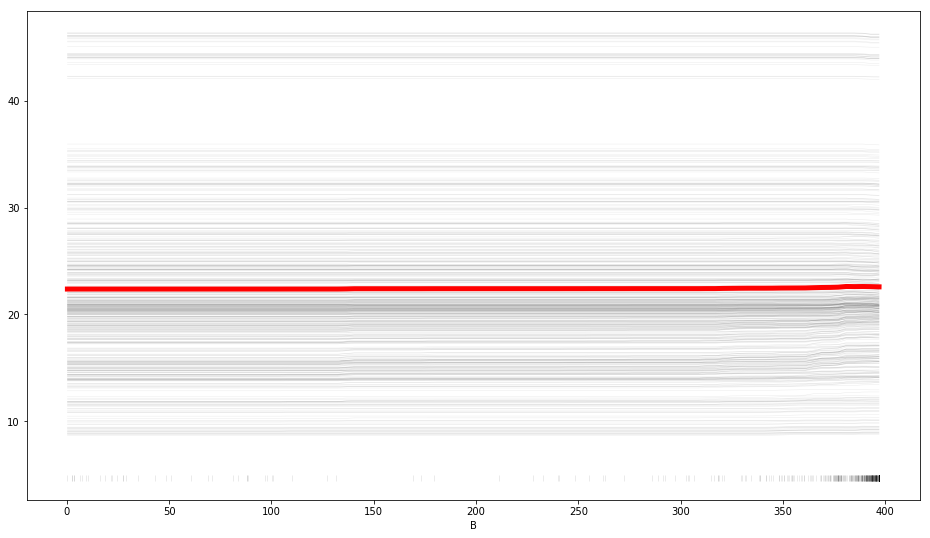

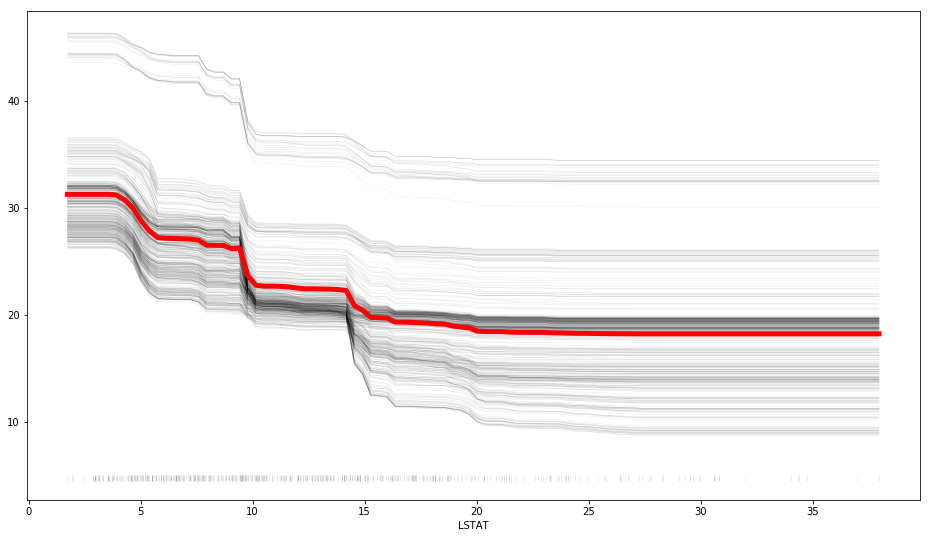

In [8]:
from partial_dependence_plot import plot_ice

for f, feature_name in enumerate(dataset.columns):
    feature_type = 'continuous'
#     feature_type = feature_type_mapping[feature_name]
    ice_df = plot_ice(model=model,
                      features=X, 
                      feature_number=f, 
                      feature_name=feature_name, 
                      feature_type=feature_type)
    
    if feature_type == 'discrete':
        ax = ice_df.plot(figsize=(16, 9), 
                         legend=False, 
                         marker='o', 
                         linewidth=0.5, 
                         markersize=1, 
                         color='black', 
                         alpha=0.08)
        ice_df.mean(axis=1).plot(c='red', 
                                 linewidth=1, 
                                 legend=False, 
                                 ax=ax, 
                                 marker='o', 
                                 markersize=7)
        
    elif feature_type == 'continuous':
        ax = ice_df.plot(figsize=(16, 9), 
                         c='k', 
                         alpha=0.08, 
                         legend=False, 
                         linewidth=0.5)
        ice_df.mean(axis=1).plot(c='red', 
                                 linewidth=5, 
                                 legend=False, 
                                 ax=ax)

        bottom, top = ax.get_ylim()
        indicator_height = 0.05 * (top - bottom)
        ax.plot(dataset[feature_name].values, 
                [bottom - indicator_height] * dataset.shape[0], 
                '|', 
                color='k',
                alpha=0.08)

# Permutation importance

In [10]:
def mean_absolute_error(y_test, y_pred):
    return np.mean(np.abs(y_test - y_pred))

In [11]:
from permutation_importance import permutation_importance_one_feature

err = permutation_importance_one_feature(model=model,
                                   X=X, 
                                   y=y,
                                   feature_number=5,
                                   error_func=mean_absolute_error)

0
100
200
300
400
500
600
700
800
900


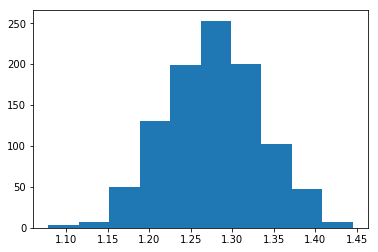

In [19]:
ax = plt.hist(err)

In [16]:
from permutation_importance import permutation_importance

ref_df = permutation_importance(model=model,
                                X=X, 
                                y=y,
                                feature_names=dataset.columns,
                                error_func=mean_absolute_error)

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


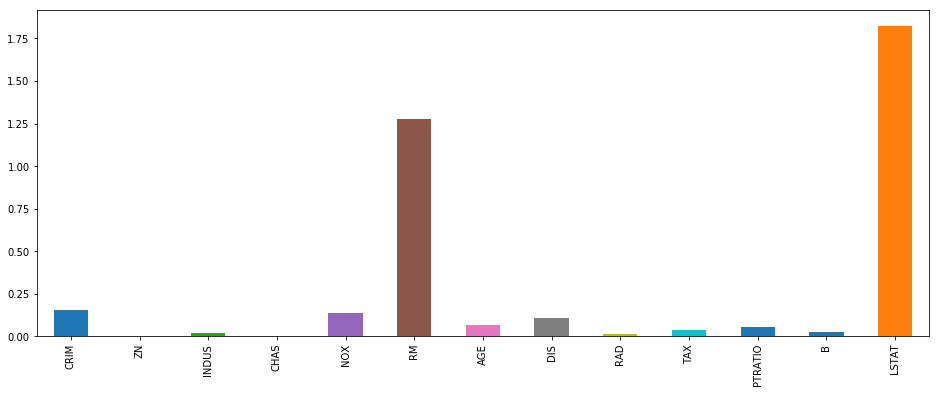

In [17]:
ref_df.mean().plot.bar(figsize=(16, 6))

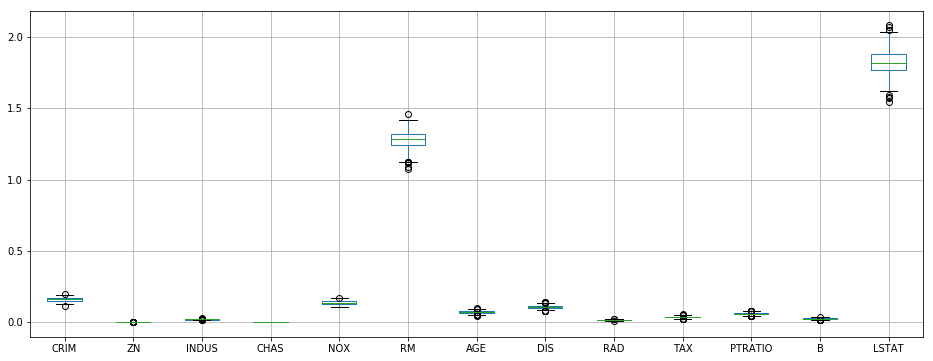

In [18]:
ref_df.boxplot(figsize=(16, 6))